In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as inter
from scipy.optimize import curve_fit
%matplotlib inline

Function definitions and some other parameters

In [2]:
n = 10000000 # 1 sample is 1/n*1.6ms

freq = 311.25 # MHz, observed band
p_spin = 1.6 # ms, spin period

freq *= 1e6 #MHz to Hz
p_spin *= 1e-3 #ms to s

p_phase = 1./freq # s, E field oscillation period
R = 6.273 # s, pulsar-companion distance

intime = p_spin/n # sample -> time in s conversion factor
insample = n/p_spin # time in s -> samples conversion factor

# x in the following functions should be in s

def tau_str(x):
    return 1e-5
def tau_geom(x):
    return x**2/(2.*R)
def tau_phase(x):
    return -tau_str(x) + tau_geom(x)
def tau_group(x):
    return tau_str(x) + tau_geom(x)

# Gaussian for fitting
def gaussian(x,a,b,c):
    return a * np.exp(-(x - c)**2/(2 * b**2))

Load a mean pulse profile for B1957+20, and fit a gaussian to the main pulse

In [3]:
# The grid size of mean_profile.npy is 1000
mean_profile = np.load('mean_profile.npy')

meanprof_Jy = (mean_profile / np.median(mean_profile) - 1) * 12.
x = np.arange(1000)
popt, pcov = curve_fit(gaussian, x, meanprof_Jy, bounds=([-np.inf,-np.inf,800.],[np.inf,np.inf,890.]))

(-0.1, 0.8)

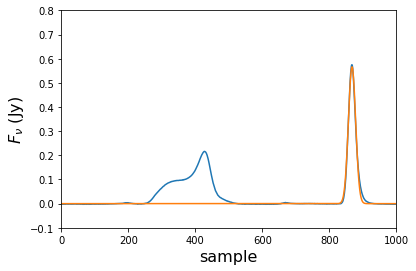

In [4]:
plt.plot(meanprof_Jy)
plt.plot(x, gaussian(x, *popt))
plt.xlabel('sample', fontsize=16)
plt.ylabel(r'$F_{\nu}$ (Jy)', fontsize=16)
plt.xlim(0,1000)
plt.ylim(-.1, 0.8)

Isolate the main pulse, sqrt it, and center

In [5]:
x = np.arange(n)

pulse_params = popt
pulse_params[1] *= n/1000 # resizing the width to current gridsize
pulse_params[2] = n/2 # centering

pulse_ref = gaussian(x, *pulse_params)
pulse_ref = np.sqrt(pulse_ref)

(-0.1, 0.8)

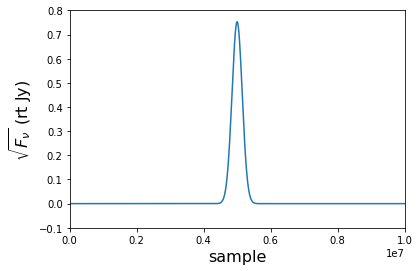

In [6]:
plt.plot(pulse_ref)
plt.xlabel('sample', fontsize=16)
plt.ylabel(r'$\sqrt{F_{\nu}}$ (rt Jy)', fontsize=16)
plt.xlim(0,n)
plt.ylim(-.1, 0.8)

Invent some sinusoidal wave at frequency of observed band

In [7]:
angular_freq = 2*np.pi*freq
t = np.linspace(0., p_spin, n)
phase_ref = np.exp(1j*angular_freq*t)

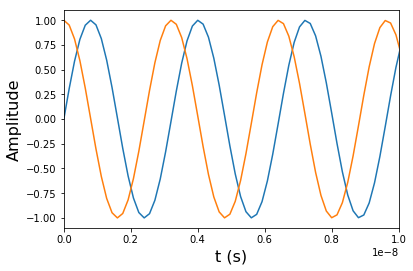

In [8]:
plt.plot(t, phase_ref.imag)
plt.plot(t, phase_ref.real)
plt.xlim(0, 1e-8)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('t (s)', fontsize=16)
plt.ylabel(r'Amplitude', fontsize=16)

Compute an electric field

In [9]:
a = 109797  # rt(kg)*m/s^2/A; a = sqrt(2*16MHz/(c*n*epsilon_0)), conversion factor between
            # sqrt(Jansky) and E field strength assuming n=1 and a 16MHz bandwidth

b = 1e-13   # rt(kg)/s; a*b = 1.1e-8 V/m

E_field_ref = a*b*pulse_ref*phase_ref
E_field_ref = np.roll(E_field_ref, (int)(1e-5*insample))

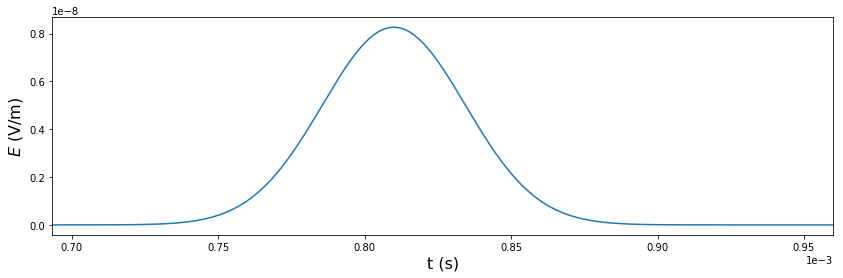

In [10]:
plt.figure(figsize=(14,4))
plt.plot(t, np.abs(E_field_ref))
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.xlim((n/2-n/15)*intime,(n/2+n/10)*intime)
plt.xlabel('t (s)', fontsize=16)
plt.ylabel(r'$E$ (V/m)', fontsize=16)

In [43]:
from joblib import Parallel, delayed

E_field = np.zeros(n, dtype=np.complex128)
E_tot = np.zeros(n, dtype=np.complex128)
pulse = np.zeros(n, dtype=np.complex128)
phase = np.zeros(n, dtype=np.complex128)

k_int = 10 # Integration range = +-lim*k_int
lim = (int)(np.sqrt(p_phase*2*R)*insample) # How far does tau_geom have to go to get to one period of E oscillation
lim *= k_int

# The last argument should be >> 2*k_int to resolve oscillations of E
int_domain = np.linspace(-lim, lim, 10)

def 

#Parallel(n_jobs=2)(
for i in int_domain:
    #print i*intime
    phase = np.roll(phase_ref, (int)(tau_phase(i*intime)*insample))
    pulse = np.roll(pulse_ref, (int)(tau_group(i*intime)*insample))
    E_field = a*b*phase*pulse
    E_tot += E_field

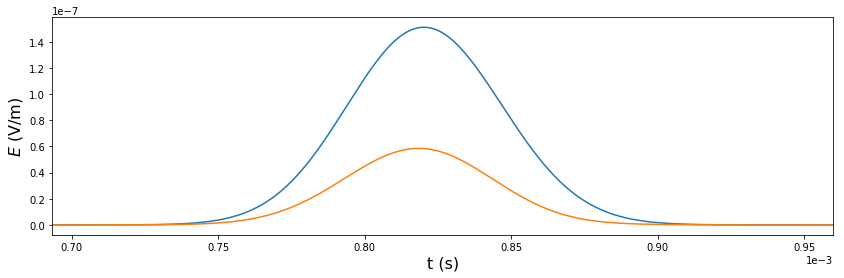

In [42]:
plt.figure(figsize=(14,4))
#plt.plot(t.reshape(-1,1e3).mean(axis=1), E_tot.reshape(-1,1e3).mean(axis=1)) # downsampling before plotting.
plt.plot(t, 10*np.abs(E_field_ref)) # 'theoretical' E field scaled up for reference
plt.plot(t, np.abs(E_tot))
plt.xlim((n/2-n/15)*intime,(n/2+n/10)*intime)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.xlabel('t (s)', fontsize=16)
plt.ylabel(r'$E$ (V/m)', fontsize=16)